<h1>Topic Modeling with Latent Dirichlet Allocation</h1>


<h2>Introduction</h2>
<p>For my project I will identify latent topics within a corpus of text using Latent Dirichlet Allocation (LDA) and Term Frequency – Inverse Document Frequency vectorization (Blei et al.). This project will be an unsupervised approach as the dataset is unlabeled and based off Blei et al’s approach. Some of the drawbacks to using Latent Dirichlet Allocation could be the length of the reports. This is due to LDA topic modeling being built to be used with larger documents and the limited number of tokens could hinder the ability for the model to perform. To account for this one approach would be to limit the corpus composed of tokens of a length longer than 256 (Weisser et al., 2022). Additionally, there are other methods for topic modeling such as BERTopic and Gibbs Sampling Dirichlet Multinomial Mixture which are reported as performing better on shorter text (Weisser et al., 2022). Though, for implementing my own algorithm I chose LDA as an introduction to creating the algorithm needed for breaking unstructured text into topics (Blei et al.). The selected corpus is composed of the Mutual UFO Network (MUFON) sighting reports to identify if there are any common topics across the reports. In addition to the MUFON data set containing unstructured text there is geospatial data for where the reporting was located leading to my hypothesis. Where if I were an alien looking to land in the United States, what does MUFON know about me in different parts of the United States based on their reporting data?</p>

<p>The Dataset being used was found on kaggle and contains over 100,000 full UFO siteing reports in additon to geospatial information: <a href = https://www.kaggle.com/datasets/joebeachcapital/ufo-sightings>Dataset Link</a></p>

In [ ]:
# Required Imports

import string
import gensim
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.map import LayerControl

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

from collections import defaultdict

<h2>Methods</h2>
<p>The following steps will be applied to perfrom topic modeling using Latent Dirichlet Allocation:</p>
<p>1. Clean and tokenize each report observation within the corpus of text.</p>
<p>2. Create bigrams based off cleaned and tokenized text.</p>
<p>3. Filter reports to only locations within the United States and that have a list of tokens longer than 96 tokens. This should help account for LDA's limited ability for building topics based on shorter text.</p>
<p>4. Create bag of words and TF-IDF matrix.</p>
<p>5. Train LDA model using both bag of words an TF-IDF matrix. Then determine the opitmal number of topics based on the hightest Coherence Value score. Since this is an upsupervised learning algorithm there are no ways to account for loss and accuracy of the results.</p>
<p>6. Identify what the topics mean based of the highest weight tokens within each topic, then assign labels.</p>
<p>7. Label each report observation with its most likely topic that the observations tokens fit into (make predictions)</p>
<p>8. Analyze Results, and determine if the hypothesis can be answered.</p>

<p>Below many of these methods are applied within the TopicModel class where I apply methods 1 through 5.</p>

In [8]:
class TopicModel:
    def __init__(self):
        """Initialize the TopicModel class."""
        self.data = pd.DataFrame()
        self.tfidf = pd.DataFrame()
        self.high_freq_words: list[str] = []
        self.word_freq: pd.Series = pd.Series()
        self.model = None

    def load_data(self, file_path: str, token_len: int = 64, threshold: float = 1.0) -> None:
        """
        Load and preprocess data from a CSV file.

        Args:
            file_path (str): Path to the CSV file containing the data.
            token_len (int): Minimum number of tokens for a document to be included. Default is 64.
            threshold (float): Quantile threshold for high frequency words. Default is 1.0.
        """
        self.data = pd.read_csv(file_path)
        self.data = self.data.dropna(subset=['text']).reset_index(drop=True)
        
        # Tokenize and clean text
        self.data['tokens'] = self.data['text'].astype('str').apply(self.clean_and_tokenize)
        self.data['tokens_with_bigrams'] = self.make_bigrams(self.data['tokens'])
        self.data['num_tokens'] = self.data['tokens_with_bigrams'].apply(len)
        
        # Filter data based on token length and country
        self.data = self.data[(self.data['num_tokens'] >= token_len) & (self.data['country'] == 'USA')].reset_index(drop=True)
        
        # Calculate word frequencies
        self.word_freq = pd.Series([word for sublist in self.data['tokens_with_bigrams'] for word in sublist]).value_counts()
        high_freq_threshold = self.word_freq.quantile(threshold)
        self.high_freq_words = self.word_freq[self.word_freq > high_freq_threshold].index.tolist()
        
        # Filter tokens
        self.data['filtered_tokens'] = self.data['tokens_with_bigrams'].apply(lambda tokens: [token for token in tokens if token not in self.high_freq_words])
        
        # Create dictionary and corpus
        self.dictionary = Dictionary(self.data['filtered_tokens'])
        self.corpus = [self.dictionary.doc2bow(text) for text in self.data['filtered_tokens']]

    def create_tfidf(self) -> None:
        """
        Create a TF-IDF matrix for the filtered tokens.
        """
        # Calculate term frequency (TF)
        tf = pd.DataFrame(self.data['filtered_tokens'].apply(self.create_word_dict).tolist()).fillna(0)
        tf = tf.apply(pd.to_numeric)
        
        # Calculate inverse document frequency (IDF)
        N = len(self.data)
        idf = tf.astype(bool).sum(axis=0).apply(lambda x: np.log((N + 1) / (x + 1))) + 1
        
        # Compute TF-IDF
        self.tfidf = tf * idf

    def plot_high_freq_words(self, num_words: int) -> None:
        """
        Plot the highest frequency words.

        Args:
            num_words (int): Number of top frequent words to plot.
        """
        plt.figure(figsize=(50, 15))
        plt.plot(self.word_freq.index[:num_words], self.word_freq.values[:num_words])
        plt.show()

    def replace_dates_with_placeholder(self, tokens: list[str]) -> list[str]:
        """
        Replace dates in the tokens with a placeholder.

        Args:
            tokens (list[str]): List of tokens.

        Returns:
            list[str]: List of tokens with dates replaced by the placeholder "<DATE>".
        """
        date_pattern = r'\d{2}/\d{2}/\d{4}'
        return ["<DATE>" if re.match(date_pattern, token) else token for token in tokens]

    def clean_and_tokenize(self, text: str) -> list[str]:
        """
        Clean and tokenize the text.

        Args:
            text (str): Text to be cleaned and tokenized.

        Returns:
            list[str]: List of cleaned and tokenized words.
        """
        text = text.replace('/', ' ')
        tokens = word_tokenize(text)
        tokens = [token.lower() for token in tokens if token not in string.punctuation]
        
        # Remove stopwords
        stop_words = set(stopwords.words('english') + ['light', 'lights', 'object', 'like', 'would', 'could', 'looked', 'br', 'flightradar24', "n't"])
        tokens = [token for token in tokens if token not in stop_words]
        
        # Remove punctuation and non-alphabetic characters
        tokens = [token.replace('.', '') for token in tokens]
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
        tokens = [token for token in tokens if token not in string.punctuation]
        tokens = [token for token in tokens if len(token) > 2]
        
        # Apply stemming
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def create_word_dict(self, tokens: list[str]) -> dict[str, int]:
        """
        Create a word frequency dictionary for a list of tokens.

        Args:
            tokens (list[str]): List of tokens.

        Returns:
            dict[str, int]: Dictionary with word frequencies.
        """
        word_dict = {i: 0 for i in set(tokens)}
        for i in tokens:
            word_dict[i] += 1
        return word_dict

    def make_bigrams(self, tokens: list[list[str]]) -> list[list[str]]:
        """
        Create bigrams from tokens.

        Args:
            tokens (list[list[str]]): List of token lists.

        Returns:
            list[list[str]]: List of token lists with bigrams.
        """
        bigram_model = Phrases(tokens, min_count=5, threshold=100)
        bigram_phraser = Phraser(bigram_model)
        return [bigram_phraser[doc] for doc in tokens]

    def train(self, tfidf: bool = False, show_tokens: bool = True, k_values: tuple[int, int] = (1, 10), num_passes: int = 10) -> None:
        """
        Train an LDA model with different numbers of topics and evaluate coherence.

        Args:
            tfidf (bool): Whether to use TF-IDF weighting. Default is False.
            show_tokens (bool): Whether to print tokens for each topic. Default is True.
            k_values (tuple[int, int]): Range of topic numbers to try. Default is (1, 10).
            num_passes (int): Number of passes for training. Default is 10.
        """
        topic_nums = range(k_values[0], k_values[1])
        results = []

        # Use TF-IDF or regular corpus
        if not tfidf:
            corpus = self.corpus
        else:
            tfidf_model = gensim.models.TfidfModel(self.corpus)
            corpus = tfidf_model[self.corpus]
        
        # Train LDA model for different numbers of topics
        for num_topics in topic_nums:
            lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=self.dictionary, num_topics=num_topics, random_state=20, passes=num_passes, workers=6)
            cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=self.dictionary, coherence='u_mass')
            cm_cv = CoherenceModel(model=lda_model, texts=self.data['filtered_tokens'], dictionary=self.dictionary, coherence='c_v')
            
            umass_score = cm_umass.get_coherence()
            cv_score = cm_cv.get_coherence()
            results.append((num_topics, umass_score, cv_score))
            
            print(f"Topics: {num_topics}, UMass: {umass_score}, CV: {cv_score}")
            if show_tokens:
                for idx, topic in lda_model.print_topics(-1):
                    print(f"Topic: {idx} \nWords: {topic}\n")
                print('*' * 50)
        
        # Select the best model based on CV score
        best_model = max(results, key=lambda x: x[2])
        self.results = results
        self.model = gensim.models.LdaMulticore(corpus=corpus, id2word=self.dictionary, num_topics=best_model[0], random_state=20, passes=num_passes, workers=6)

    def plot_training(self) -> None:
        """
        Plot the UMass and CV coherence scores against the number of topics.
        """
        x, y1, y2 = zip(*self.results)
        y2 = [i * 100 for i in y2]
        
        plt.figure(figsize=(25, 10))
        plt.plot(x, y1, label='UMass Values', color='blue', marker='o')
        plt.plot(x, y2, label='Coherence Values', color='red', marker='x')
        plt.title('Plot of UMass Score and CV Score against Number of Topics')
        plt.xlabel('Num Topics')
        plt.ylabel('Coherence Values')
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_topic_pred(self, text: list[str]) -> tuple[int, float]:
        """
        Get the topic prediction for a given text.

        Args:
            text (list[str]): List of tokens representing the text.

        Returns:
            tuple[int, float]: The topic number and its corresponding probability.
        """
        bow = self.dictionary.doc2bow(text)
        topics = self.model.get_document_topics(bow)
        return max(topics, key=lambda x: x[1])

<h2>Exploring how to create the Term Frequency - Inverse Document Frequency Matrix</h2>

TF Matrix:

$$ \text{TF}(m, n) = \frac{\text{Number of times token } m \text{ appears in document } d}{\text{Total number of tokens in document } d} $$

Inverse Document Matrix:

$$ \text{IDF}(n) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents with token } m \text{ in them}}\right) $$

Lastly the Term Frequency Inverse Document Frequency Matrix is identified as:

$$\text{TF}(m, n) * {IDF}(n) = {TFIDF}(m , n) $$

<p>The Term Frequency Inverse Document Frequency Matrix provides a more accurate distribution of the tokens within my dataset. This is done reducing the weights of commonly occuring words such as stop words, though the weights of words that could be considered more rare within the corpus are increased. This could prove to be helpful when creating my topics as I'm looking to identify unique sub topics within the corpus focusing on possible encounters with intellgent life. If a token such as alien or bigfoot are mentioned many times in one document TFIDF will maximize the weights of those unique tokens, and I'm hoping to use this to my benefit to better identify latent topics.</p>

In [9]:
# initialize our the class for our model and load in the data.

topic_model = TopicModel()
topic_model.load_data(r"C:\Users\jared\Documents\CS542\project\archive (5)\timothyrenner-ufo-sightings\timothyrenner-ufo-sightings\nuforc_reports.csv", threshold=0.995)

Below the first five documents in the dataset are explored and used to create the term frequency matrix. This is done by identifying all the uniuqe tokens within the provided corpus. Then, incrementing by 1 for each time a token is seen within one report (or row of data). This will result in in an m x n matrix where m is our number of documents being observed and n is the number of unique tokens within the selected documents.

In [10]:
# Explore a small subset of the first five thousand documents in the NUFORC dataset.

tf = pd.DataFrame(topic_model.data['filtered_tokens'][:5000].apply(topic_model.create_word_dict).tolist()).fillna(0)
tf = tf.apply(pd.to_numeric)
tf

,vertic,faa,streak,rout,crew,airlin,hr,daylight,june,hotlin,...,anguish,reconcil,bystand,striber,discomfort,parimet,overweight,predominatli,withheld,stigmata
0,1.0,3.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Next the Inverse Document frequency is created. This will result in an m x 1 vector where m is the number of unique tokens corresponding to the term frequency matrix column names.

In [11]:
# Calculate Inverse Document Frequency (IDF)
N = len(topic_model.data['filtered_tokens'][:5000])
idf = tf.astype(bool).sum(axis=0).apply(lambda x: np.log((N + 1) / (x + 1))) + 1
idf

vertic          4.259898
faa             5.547101
streak          4.070656
rout            4.568633
crew            6.083406
                  ...   
parimet         8.824246
overweight      8.824246
predominatli    8.824246
withheld        8.824246
stigmata        8.824246
Length: 23015, dtype: float64

<p>Below is the final result for my Initial TFIDf matrix where you can see how some tokens such as "crew_member" were maximized within the first document, and others were minimized such as "pacif" and "listen". This indiciates that "crew_member" was likely of more importance within the first document compared to the other two tokens.</p>

In [12]:
# lastly multiply the tf and idf matracies together to obtain the tfidf matrix.
tfidf = tf * idf
tfidf

,vertic,faa,streak,rout,crew,airlin,hr,daylight,june,hotlin,...,anguish,reconcil,bystand,striber,discomfort,parimet,overweight,predominatli,withheld,stigmata
0,4.259898,16.641304,4.070656,9.137267,12.166812,13.972742,4.721603,4.912223,5.063046,6.426351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.063046,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.824246,8.824246,8.824246,8.824246,8.824246,8.824246,8.824246,0.000000,0.000000,0.000000
4998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.824246,0.000000,0.000000


<h3>Identify the top 20 highest occuring tokens</3h>

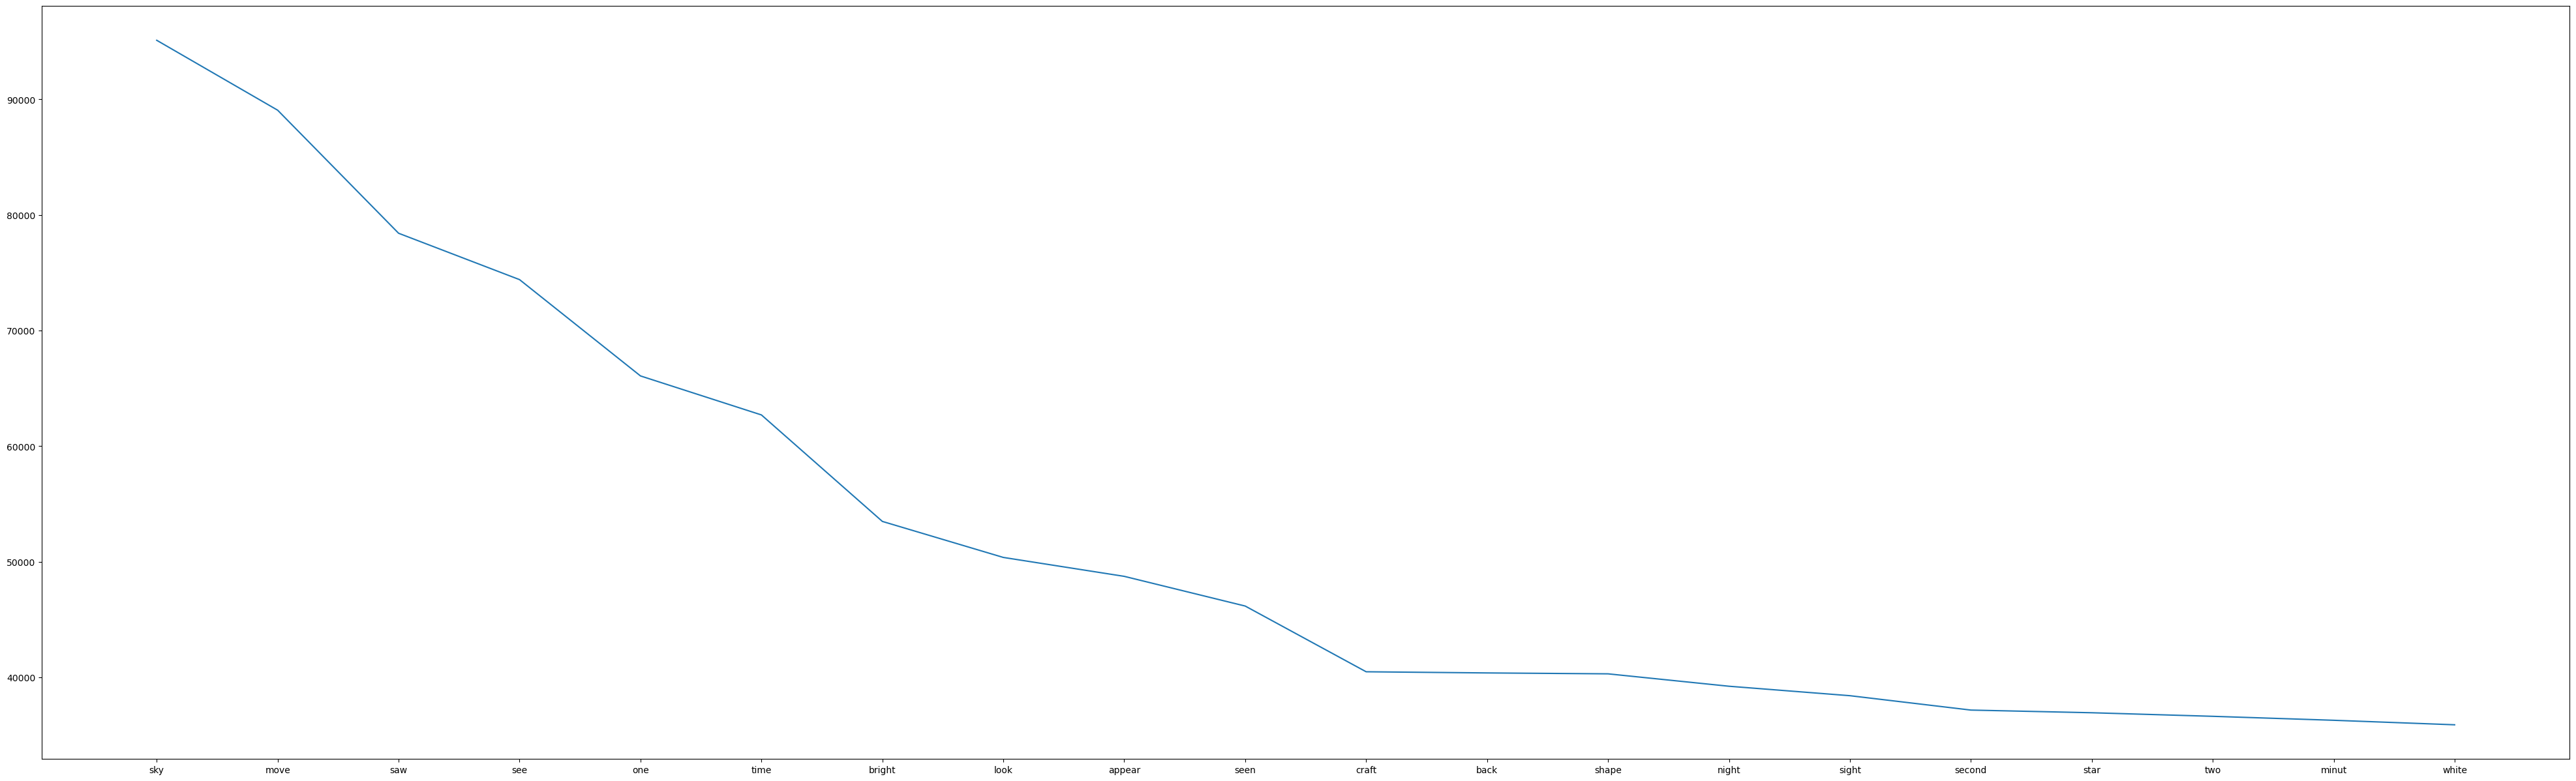

In [53]:
topic_model.plot_high_freq_words(20)

<h2>Train Latent Dirichlet Allocation Model using the TFIDF matrix</h2>

Thankfully gensim provides the ability to use TFIDF built into the package. This is the same package I'll be using to pefrom Latenet Dirichlet Allocation. Though, it will be trained using two variations of matricies, one is a bag of words approach and the other is using the TFIDF matrix. Based off these results and the hyperparameter optimization the best distribution of topics will be selected and then labled based on their top weighted tokens. I initially tried implamenting this algorithm from scratch but then realized I was quickly in over my head. Additionally, I used k-means clustering with my TFIDF matrix but realized my results were not as accurate. In hopes of working towards answering my hypothesis, I reverted back to utlizing gensim to apply the LDA topic model.

<h2>Training using the TFIDF matrix</h2>

In [17]:
topic_model.train(tfidf = True, k_values=(1,25))

Topics: 1, UMass: -3.045918761417842, CV: 0.17676588302345544
Topic: 0 
Words: 0.001*"firework" + 0.001*"drone" + 0.001*"reappear" + 0.001*"flicker" + 0.001*"dot" + 0.001*"northeast" + 0.001*"rotat" + 0.001*"drop" + 0.001*"horizont" + 0.001*"southwest"

**************************************************
Topics: 2, UMass: -3.258850049216767, CV: 0.46830488633197587
Topic: 0 
Words: 0.002*"didnt" + 0.001*"dont" + 0.001*"wasnt" + 0.001*"couldnt" + 0.001*"lite" + 0.001*"stope" + 0.001*"that" + 0.001*"disapear" + 0.001*"dissapear" + 0.001*"ive"

Topic: 1 
Words: 0.001*"drone" + 0.001*"firework" + 0.001*"dot" + 0.001*"reappear" + 0.001*"rotat" + 0.001*"northeast" + 0.001*"horizont" + 0.001*"flicker" + 0.001*"drop" + 0.001*"southwest"

**************************************************
Topics: 3, UMass: -11.340889621993739, CV: 0.3811809838835118
Topic: 0 
Words: 0.000*"stope" + 0.000*"verri" + 0.000*"brian_vike" + 0.000*"didnt" + 0.000*"sioux_fall" + 0.000*"pari" + 0.000*"reali" + 0.000*"bel

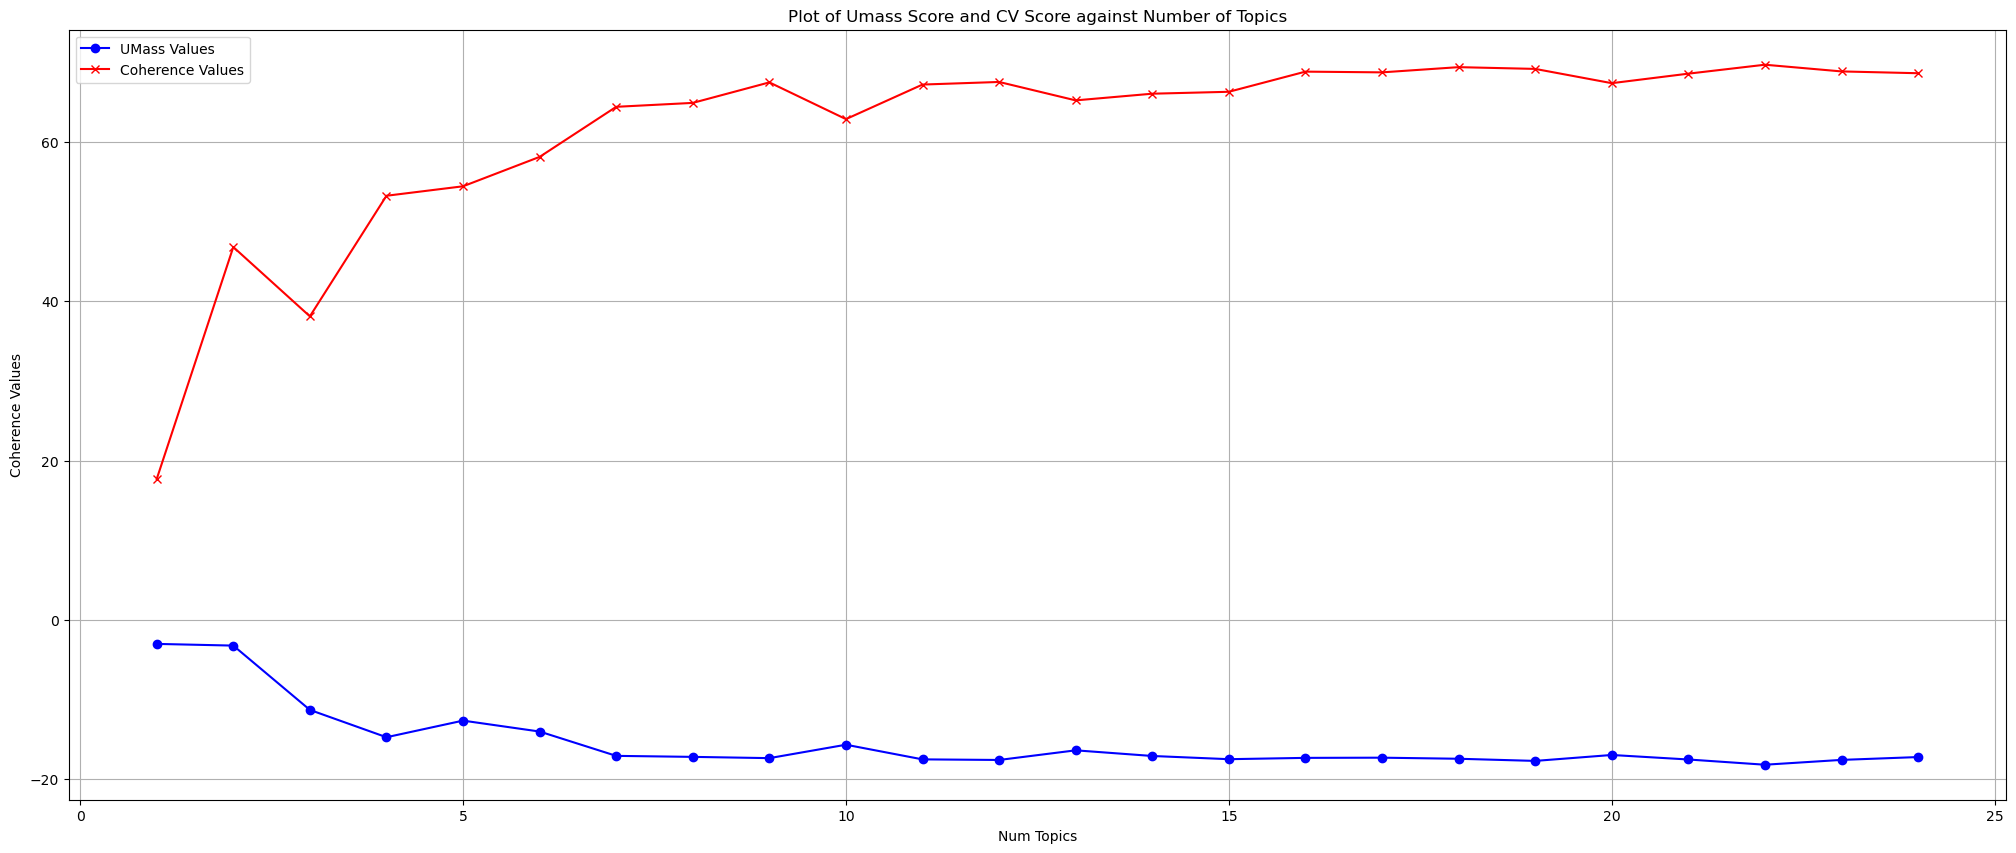

In [18]:
topic_model.plot_training()

<h2>Training Using a Bag of Words</h2>

In [19]:
topic_model.train(tfidf = False, k_values=(1,25))

Topics: 1, UMass: -2.7798788106127166, CV: 0.1610355000631479
Topic: 0 
Words: 0.002*"saucer" + 0.002*"rotat" + 0.002*"room" + 0.002*"thank" + 0.001*"mph" + 0.001*"drop" + 0.001*"wind" + 0.001*"usual" + 0.001*"sourc" + 0.001*"famili"

**************************************************
Topics: 2, UMass: -2.7126413848314357, CV: 0.43821892798533224
Topic: 0 
Words: 0.003*"room" + 0.003*"scare" + 0.003*"truck" + 0.003*"saucer" + 0.003*"sister" + 0.003*"mom" + 0.003*"alien" + 0.003*"real" + 0.003*"weird" + 0.003*"sleep"

Topic: 1 
Words: 0.003*"firework" + 0.002*"northeast" + 0.002*"drone" + 0.002*"southwest" + 0.002*"horizont" + 0.002*"northwest" + 0.002*"steadi" + 0.002*"commerci" + 0.002*"southeast" + 0.002*"reappear"

**************************************************
Topics: 3, UMass: -2.809952402007816, CV: 0.4147903866617961
Topic: 0 
Words: 0.004*"truck" + 0.004*"scare" + 0.004*"room" + 0.004*"wood" + 0.003*"sleep" + 0.003*"sat" + 0.003*"water" + 0.003*"sudden" + 0.003*"loud" + 0.0

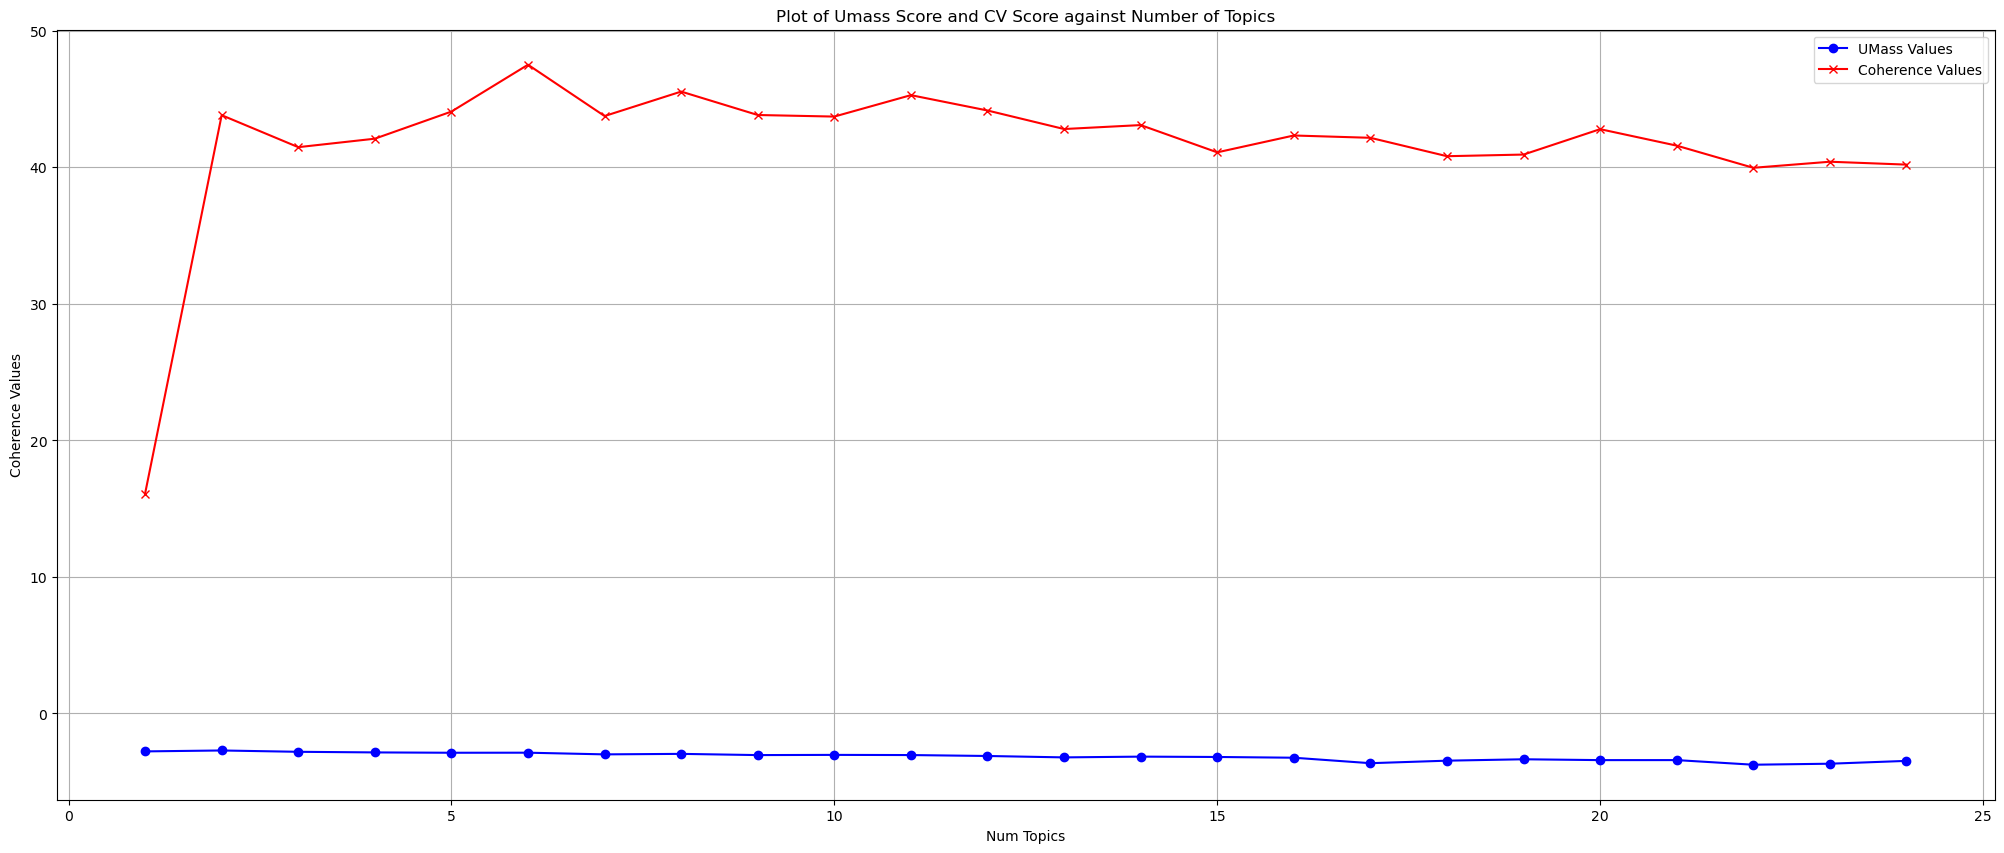

In [20]:
topic_model.plot_training()

Retrain the model using the best topic model from either bag of words, or tfidf matrix. This model is was the based on the TFIDF matrix with a cv score of 0.69 and a k number of topics eqaul to 9. The TopicModel class automatically selects the highest scoring model based on the cv score. Though, when doing it this way you could introduce over training into the model. The best method to avoid this is by using the elbow method and identify the highest scoring CV score before the scores taper off and stop increasing. Based on my chart above and the results of my training the optimal number of topics is 9. Though, after looking through the topics there were not many results that indicataed an answer to my hypothesis. Based on this I went back and looked through all iterations of my topics based on the k values between the range 5 and 21 to identify if any topics indicate possible encounters with alien life. This resulted in identifying the number of topics as 12 and the appropriate labels were assigned below.

In [21]:

topic_model.train(k_values=(12,13), tfidf=True)

Topics: 12, UMass: -17.679043601887138, CV: 0.6760967463739013
Topic: 0 
Words: 0.002*"hare" + 0.001*"boardwalk" + 0.001*"medit" + 0.001*"flamelik" + 0.001*"graini" + 0.001*"baton_roug" + 0.001*"headphon" + 0.001*"thunder_storm" + 0.001*"encompass" + 0.001*"coars"

Topic: 1 
Words: 0.002*"drone" + 0.002*"firework" + 0.001*"reappear" + 0.001*"dot" + 0.001*"rotat" + 0.001*"flicker" + 0.001*"northeast" + 0.001*"drop" + 0.001*"horizont" + 0.001*"southwest"

Topic: 2 
Words: 0.002*"tic_tac" + 0.002*"tictac" + 0.002*"disregard" + 0.002*"sobermind_suspect" + 0.001*"napl" + 0.001*"maneuver" + 0.001*"cape_coral" + 0.001*"redwood" + 0.001*"counselor" + 0.001*"whiteyellow"

Topic: 3 
Words: 0.005*"chines_lantern" + 0.002*"tandem" + 0.002*"http_wwwyoutubecom" + 0.002*"via_telephon" + 0.002*"anonym_provid" + 0.001*"wsw" + 0.001*"minim" + 0.001*"iridium_flare" + 0.001*"drip" + 0.001*"louisvil"

Topic: 4 
Words: 0.002*"post_facebook" + 0.001*"pumpkin" + 0.001*"potti" + 0.001*"modesto" + 0.001*"willia

<h2>Apply Topic Predictions to each observation within the Initial Dataset</h2>

In [22]:
topic_model.model.print_topics(num_words=20)

[(0,
  '0.002*"hare" + 0.001*"medit" + 0.001*"boardwalk" + 0.001*"graini" + 0.001*"flamelik" + 0.001*"headphon" + 0.001*"baton_roug" + 0.001*"thunder_storm" + 0.001*"encompass" + 0.001*"coars" + 0.001*"aggress" + 0.001*"dog_potti" + 0.001*"semitranspar" + 0.001*"fremont" + 0.001*"cirlc" + 0.001*"dublin" + 0.001*"summon" + 0.001*"troy" + 0.001*"brentwood" + 0.001*"ping"'),
 (1,
  '0.002*"drone" + 0.002*"firework" + 0.001*"dot" + 0.001*"reappear" + 0.001*"rotat" + 0.001*"northeast" + 0.001*"horizont" + 0.001*"flicker" + 0.001*"drop" + 0.001*"southwest" + 0.001*"porch" + 0.001*"steadi" + 0.001*"sudden" + 0.001*"northwest" + 0.001*"girlfriend" + 0.001*"usual" + 0.001*"beach" + 0.001*"weird" + 0.001*"saucer" + 0.001*"zoom"'),
 (2,
  '0.002*"tictac" + 0.002*"tic_tac" + 0.002*"disregard" + 0.002*"sobermind_suspect" + 0.001*"cape_coral" + 0.001*"maneuver" + 0.001*"napl" + 0.001*"counselor" + 0.001*"redwood" + 0.001*"whiteyellow" + 0.001*"quadcopt" + 0.001*"ovallik" + 0.001*"trio" + 0.001*"stra

Based off the above tokens Im looking to see if any logical topics appear. The most sound ones are topics 2, 5, and 7 showing that they may have the best use case. I had some fun with others that clearly were grouped together such as glittery moutain stingrays. This is likely not an actual event, but is fun to see what some of the results are. I would be interested to try this with a stronger model such as BERTtopic or leveraing Retrival Augemented Generation (RAG) and what type of results can be gained.

In [23]:
labels = {0 : 'unknown',
          1: 'drones',
          2: 'tic-tac uap',
          3: 'donut aircraft',
          4: 'pumpkin chemtrails',
          5: 'military research',
          6: 'unknown',
          7: 'bigfoot',
          8: 'unknown',
          9: 'glittery mountain stringrays',
          10: 'toddler androids',
          11: 'unknown'}

In [24]:
# this is a gross lambda function and I apologize for the horror this became.

topic_model.data['preds'] = topic_model.data['filtered_tokens'].apply(lambda x: max(topic_model.model.get_document_topics(topic_model.tfidf[topic_model.dictionary.doc2bow(x)]), key=lambda i:i[1]))

In [25]:
topic_model.data['topic_num'] = topic_model.data['preds'].apply(lambda x: x[0])
topic_model.data['topic_prob'] = topic_model.data['preds'].apply(lambda x: x[1])
topic_model.data['topic_label'] = topic_model.data['topic_num'].apply(lambda x: labels.get(x))

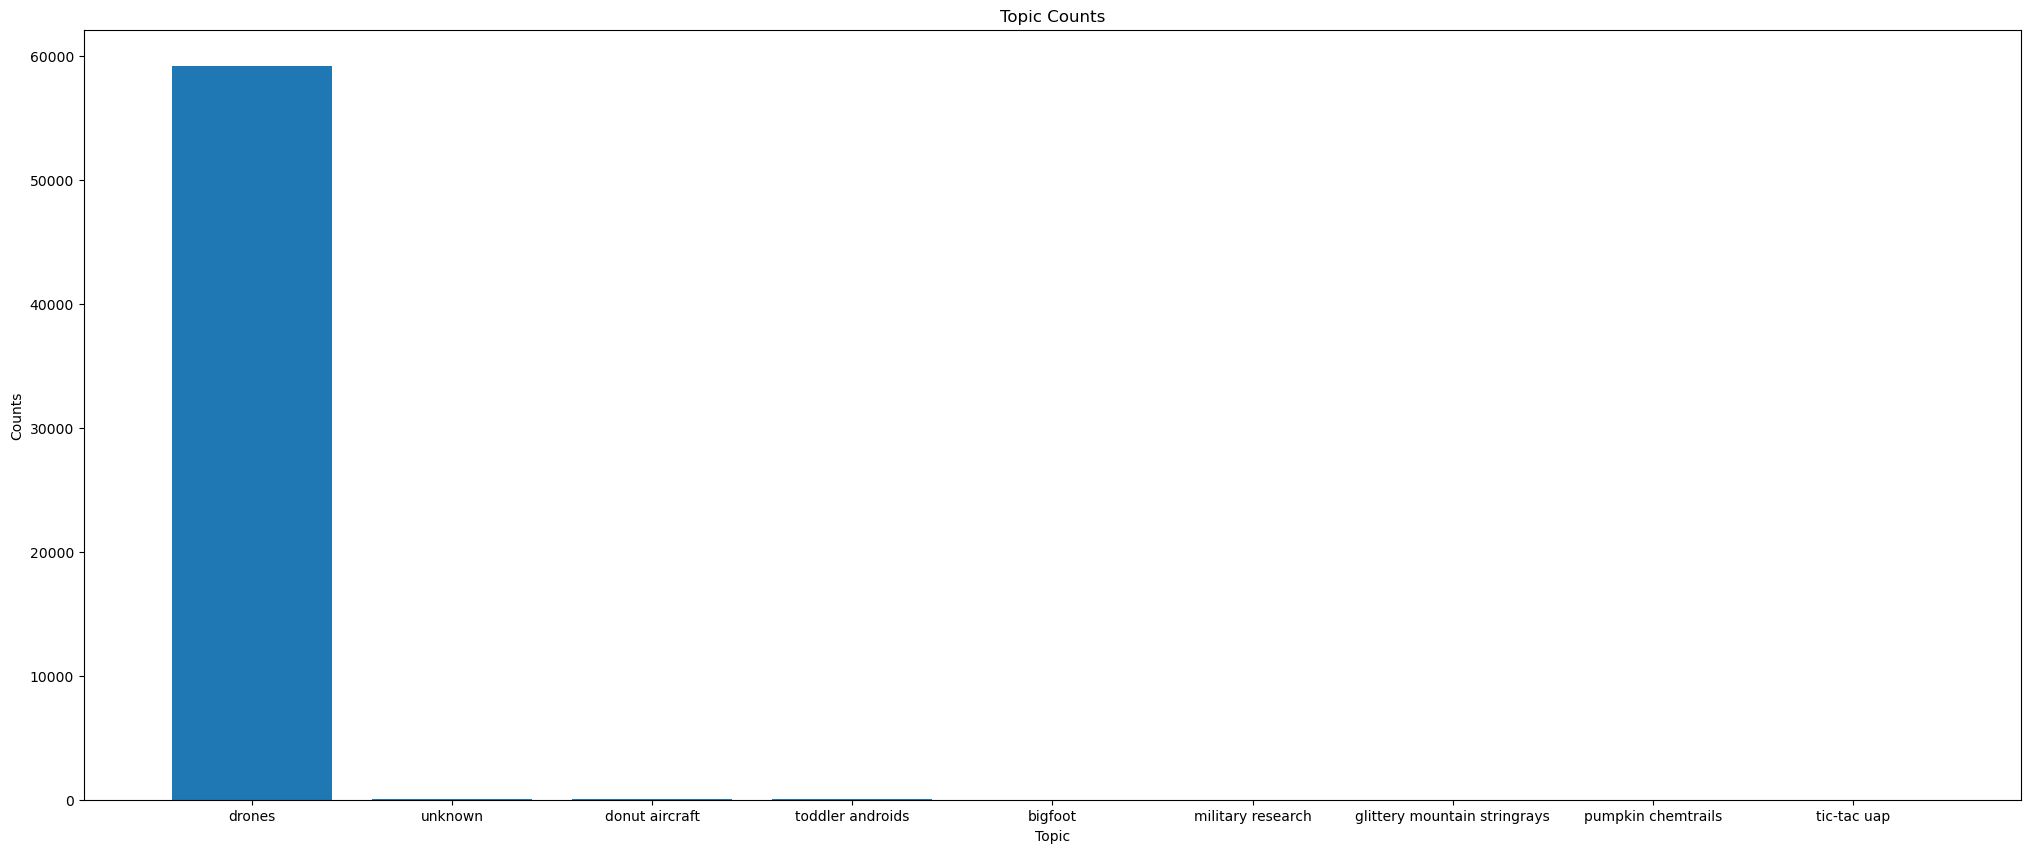

In [33]:
value_counts_dict = topic_model.data['topic_label'].value_counts().to_dict()
plt.figure(figsize=(25, 10))
plt.bar(value_counts_dict.keys(), value_counts_dict.values())

# Adding titles and labels
plt.xlabel('Topic')
plt.ylabel('Counts')
plt.title('Topic Counts')

# Show the plot
plt.show()

In [41]:
map_data = topic_model.data[~topic_model.data['city_latitude'].isna()]
map_data = map_data[~map_data['topic_label'].isin(['drones', 'unknown'])]

m = folium.Map(location=[map_data['city_latitude'].mean(), map_data['city_longitude'].mean()], zoom_start=5)

topic_group = {}

for topic_label in map_data['topic_label'].unique():
    topic_group[topic_label] = folium.FeatureGroup(name=topic_label).add_to(m)

def color_producer(topic_label):
    color_dict = {'tic-tac uap': 'green', 'bigfoot': 'blue', 'donut aircraft':'cyan', 'military research':'yellow', 'pumpkin chemtrails':'orange', 'glittery mountain stringrays':'black'} # Add your own color mappings here
    return color_dict.get(topic_label, 'red') 

for index, row in map_data.iterrows():
    if pd.notnull(row['city_latitude']) and pd.notnull(row['city_longitude']):
        folium.CircleMarker(
            location=[row['city_latitude'], row['city_longitude']],
            radius=5,
            color=color_producer(row['topic_label']),
            fill=True,
            fill_color=color_producer(row['topic_label']),
            popup=row['summary'],
        ).add_to(topic_group[row['topic_label']])

LayerControl(collapsed=False).add_to(m)

m


m

Below are one the results for where I filtered down to the tic-tac uap topic, then sorted by how well the report fit into the topic. The reports near the top show the best fitting report for that topic. This repot clearly states Tic tac crafts were observed. Though, the other reports are not as effective at fitting within the topic. After observing the dataset it could have been scraped more efficinetly from the website. This is something that would have benefit the training of the model, cleaning of the data, and amount of data avialble to create better and more distinct topics.

Above on the map we can filter down to the tic-tac uap topic and observe where all of these events occured.

In [52]:
for i in topic_model.data[topic_model.data['topic_label'] == 'tic-tac uap'].sort_values('topic_prob')['summary'].reset_index(drop = True).to_list():
    print(i)
    print()


Tic tac crafts passing each other as on two-lane highway in blue sky with puffy clouds.

THE OBJECT WAS CLOSE AND VERY LOW IN THE SKY, THUS MY DISCPRITION IN DEATAIL.

IWas walking around the park w/ my son, we were looking at clouds ,trees, i was showing him the deference in clouds and the diferenr k

I was about seven when it happened.

while driving on i690 by the lake.looking to the south.a small blue light shot down like a falling star but it blinked out not fading l



<h2>Final Analysis</h2>

<p>In my analysis, I found that employing Latent Dirichlet Allocation (LDA) with a Term Frequency-Inverse Document Frequency (TFIDF) approach, which assigns weights to words based on their importance, produced more distinct and clear results compared to the basic Bag of Words approach. However, there was a notable issue where the topics appeared to be heavily skewed towards one dominant theme. This suggests that the model might be overfitting, and it would have been advisable to select a lower value for the parameter "k," representing the number of topics. Another potential issue could be improper handling of stop words or frequent tokens during data preprocessing.<p>

<p>Despite this skewing, there were some intriguing smaller topics such as "tic-tac uap's" that emerged, leading to interesting insights when reports were grouped together. For future iterations, I would consider fine-tuning the alpha and beta hyperparameters for the LDA model and exploring the use of word embeddings instead of a TFIDF matrix. This would allow us to incorporate contextual information into the topic modeling process, potentially improving the quality of topic clusters.</p>

<p>Moreover, I plan to explore alternative topic modeling approaches such as BERTopic and GDSMM. These models may perform better, especially when dealing with shorter text reports or when aiming for a more diverse distribution of sub-topics within the reports, aligning with my original hypothesis.</p>

<p>Speaking of my hypothesis, which is centered around the question of what information MUFON (Mutual UFO Network) might have about an alien looking to land in different parts of the United States based on their reporting data, we made some progress. To address this, we filtered out irrelevant topics like drones and unidentified topics. We then focused on unique topics such as "Bigfoot" and "tic-tac uaps." These results were plotted onto a Folium map, providing a geospatial representation of where these encounters might have occurred within the United States and what the reports revealed.</p>

<p>Interestingly, the reports seemed to cluster around areas of higher population, such as California, Texas, New York, and Florida. Also, bigfoot is a confimed alien.. or florida man?</p>

<h2>Reverse Conjecture Map</h2>


<h3>Outcomes</h3>
<p>During the course of my investigation into MUFON's knowledge regarding UFO sightings across the United States, I encountered a mixture of outcomes. While I wasn't able to conclusively confirm my initial hypothesis due to certain challenges in model tuning and data selection, I did manage to acquire valuable insights into various techniques for topic modeling. The LDA (Latent Dirichlet Allocation) topic model I developed generated a total of 12 topics, approximately six of which were related to UFO or extraterrestrial sightings. One particularly noteworthy outcome was the utilization of a Folium map, which provided a visually informative representation of the geographic distribution of these topics. This project highlighted the critical role of data cleaning and tokenization in data preparation before LDA training. Unlike other natural language processing (NLP) methods where each token contributes to embeddings, LDA necessitates a more refined approach to data cleaning to yield coherent results. Through this process, I also gained valuable experience in working with Folium and effectively presenting NLP findings in an interactive format.</p>
<h3>Mediating Processes</h3>
<p>Several key artifacts were produced as part of this project, including functions for text data cleaning, tokenization, the creation of a bag of words, and the generation of a TFIDF matrix. Furthermore, I developed functions for visualizing the training results of the LDA model through charts and graphs. I conducted experiments by training the model using both the bag of words approach and the TFIDF approach, ultimately selecting the method that yielded the highest average coherence value score.</p>
<h3>Raw Artifacts</h3>
<p>TThis project was intially derived from the research by Blei et al. in 2003 on latenet dirichlet allocation. Additionally, I made use of various packages, such as gensim and Folium, to facilitate the modeling of the data into topics and to create an interactive presentation. The dataset used in this project was obtained from Kaggle and involved scraping data from the MUFON and NUFORC websites. Gensim's website provided helpful guidance on how to employ the LDAmulticore model, aiding in the process of training and evaluating the model using both the bag of words and TFIDF approaches. These resources, along with data cleaning techniques, collectively contributed to achieving more robust results in the project.</p>

<h2>Citations</h2>

Blei, D., Ng, A., & Jordan, M. (n.d.). Latent dirichlet allocation - Journal of Machine Learning Research. Latent Dirichlet Allochation. https://jmlr.org/papers/volume3/blei03a/blei03a.pdf

Gensim: Topic modelling for humans. Radim ÅehÅ¯Åek: Machine learning consulting. (2022, December 21). https://radimrehurek.com/gensim/index.html 

Nugent, C. (2017, August 15). UFO sightings around the world. Kaggle. https://www.kaggle.com/datasets/camnugent/ufo-sightings-around-the-world/data

Weisser, C., Gerloff, C., Thielmann, A., Python, A., Reuter, A., Kneib, T., & S&auml;fken, B. (2022, July 9). Pseudo-document simulation for comparing Lda, GSDMM and GPM topic models on short and sparse text using Twitter data - computational statistics. SpringerLink. https://link.springer.com/article/10.1007/s00180-022-01246-z